# Machine Predictive Maintenance Classification

김재호, 이정언

## 1. Import & Load dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

In [2]:
df_org = pd.read_csv('predictive_maintenance.csv', index_col='UDI')
df_org

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
UDI,,,,,,,,,
1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
...,...,...,...,...,...,...,...,...,...
9996,M24855,M,298.8,308.4,1604,29.5,14,0,No Failure
9997,H39410,H,298.9,308.4,1632,31.8,17,0,No Failure
9998,M24857,M,299.0,308.6,1645,33.4,22,0,No Failure


## 2. EDA - Data 탐색
+ 변수별 type과 null값 확인

In [3]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Product ID               10000 non-null  object 
 1   Type                     10000 non-null  object 
 2   Air temperature [K]      10000 non-null  float64
 3   Process temperature [K]  10000 non-null  float64
 4   Rotational speed [rpm]   10000 non-null  int64  
 5   Torque [Nm]              10000 non-null  float64
 6   Tool wear [min]          10000 non-null  int64  
 7   Target                   10000 non-null  int64  
 8   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(3), object(3)
memory usage: 781.2+ KB


### 2.1 수치형 변수

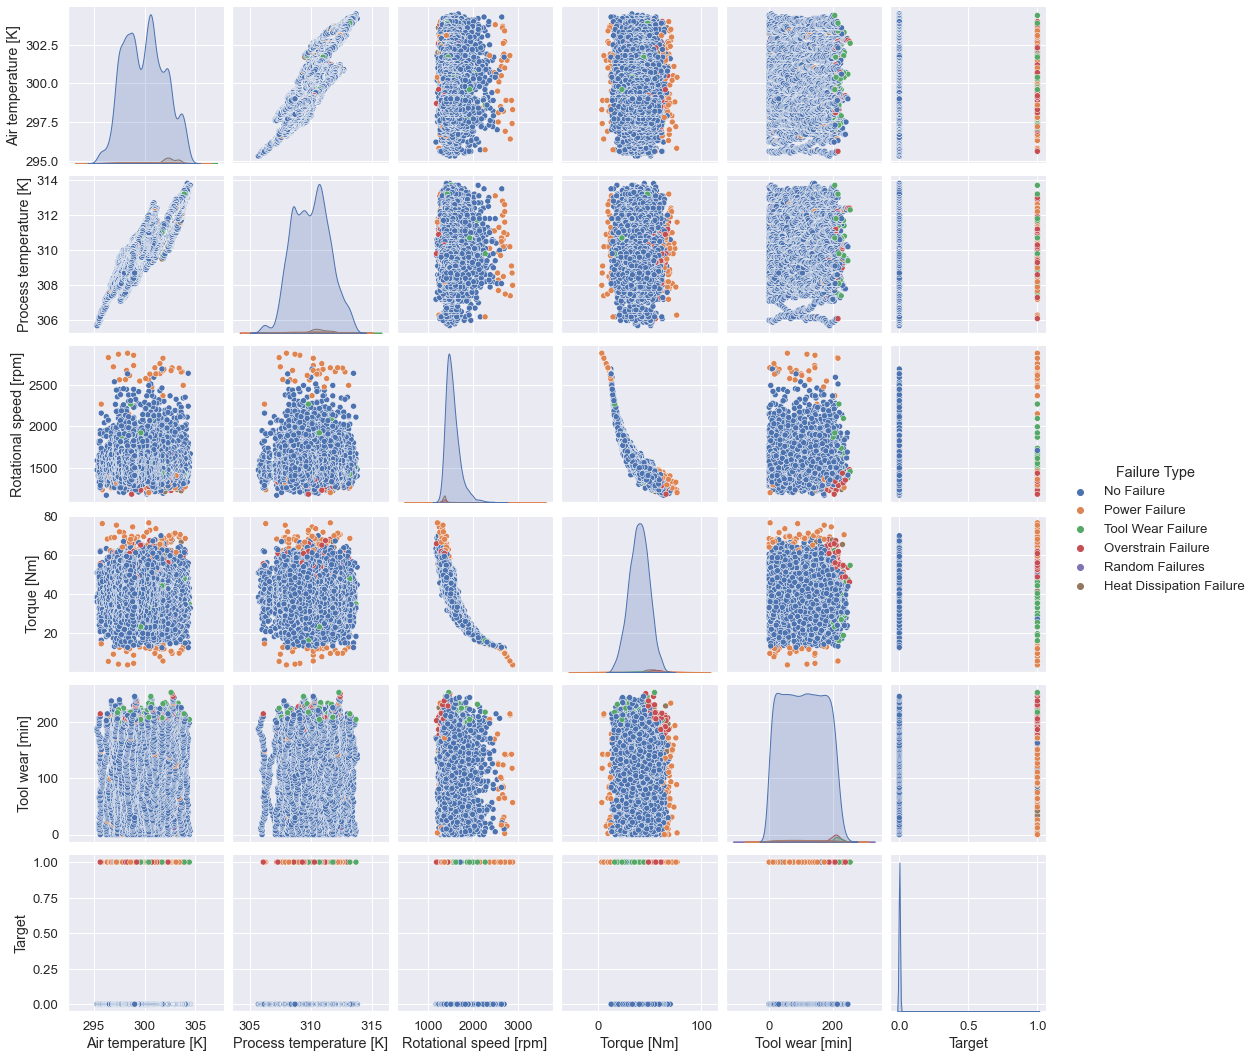

In [4]:
sns.set(font_scale=1.2)
sns.pairplot(data=df_org, hue='Failure Type', height=2.5)

+ 대체적으로 변수의 값이 높거나 낮을 때 고장이 남.
+ 주황색 power value Failure가 많이 보임
+ 눈에 띄는 이상치가 보이진 않음

array([[<AxesSubplot:title={'center':'Air temperature [K]'}>,
        <AxesSubplot:title={'center':'Process temperature [K]'}>],
       [<AxesSubplot:title={'center':'Rotational speed [rpm]'}>,
        <AxesSubplot:title={'center':'Torque [Nm]'}>],
       [<AxesSubplot:title={'center':'Tool wear [min]'}>,
        <AxesSubplot:title={'center':'Target'}>]], dtype=object)

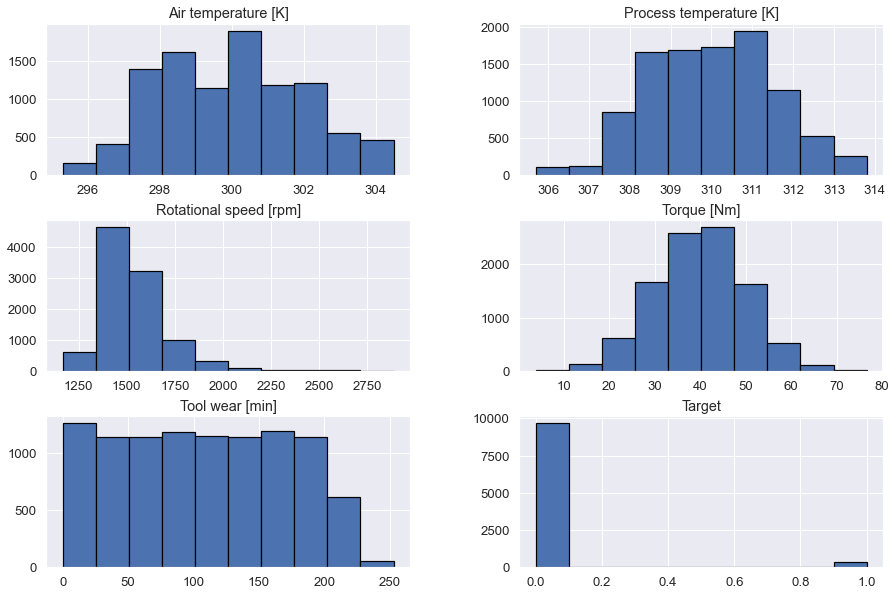

In [5]:
df_org.hist(edgecolor='black', linewidth=1.2, figsize=(15,10))

### 2.2 범주형 변수

+ Type : L,M,H
+ Failure Type :

<AxesSubplot:xlabel='Type', ylabel='count'>

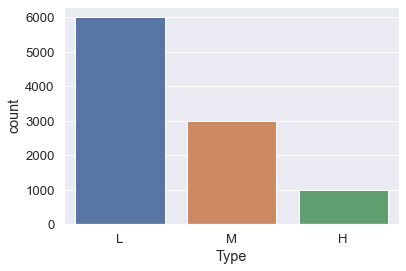

In [6]:
sns.countplot(x='Type',data=df_org, order=['L','M','H'])

<AxesSubplot:xlabel='Type', ylabel='count'>

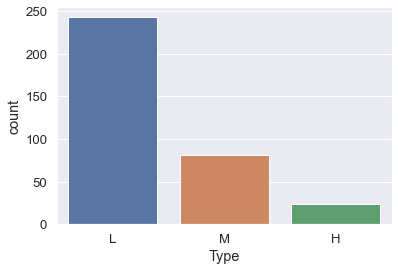

In [7]:
df_fail = df_org[df_org['Failure Type']!='No Failure'] # 고장 난 경우만
sns.countplot(x='Type', data=df_fail) # 고장 난 경우

In [8]:
df_org['Failure Type'].value_counts()

No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: Failure Type, dtype: int64

+ 고장은 1만개 중 348개, 약 3.5%

<AxesSubplot:xlabel='Failure Type', ylabel='count'>

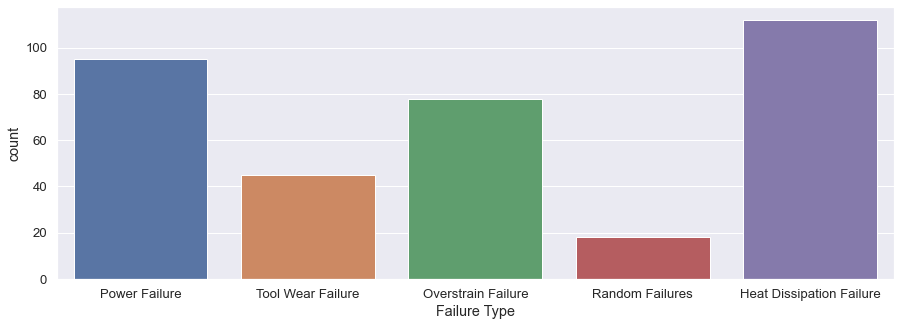

In [9]:
plt.figure(figsize=(15,5))
sns.countplot(x='Failure Type', data = df_fail)

+ Heat Dissipation Failure가 제일 많음. 그러나 앞의 pairplot에선 잘 안보였음. 시각화 필요
+ 열이랑 관련돼있을 것

<AxesSubplot:xlabel='Air temperature [K]', ylabel='Process temperature [K]'>

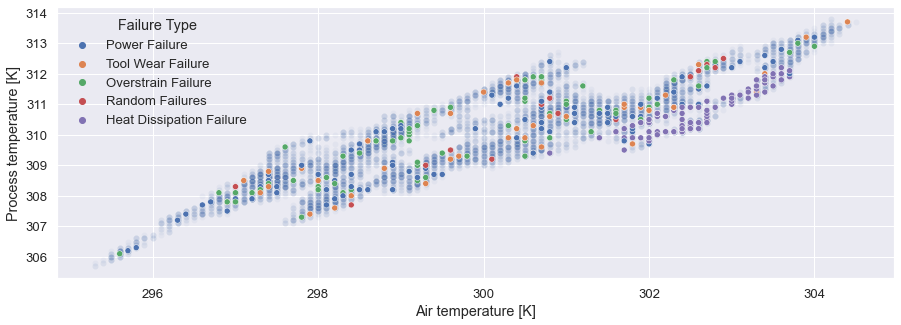

In [10]:
plt.figure(figsize=(15,5))
sns.scatterplot(x='Air temperature [K]', y='Process temperature [K]', alpha=0.05, data=df_org)
sns.scatterplot(x='Air temperature [K]', y='Process temperature [K]',
            hue='Failure Type', data=df_fail)

Text(0, 0.5, 'Process temp - Air temp')

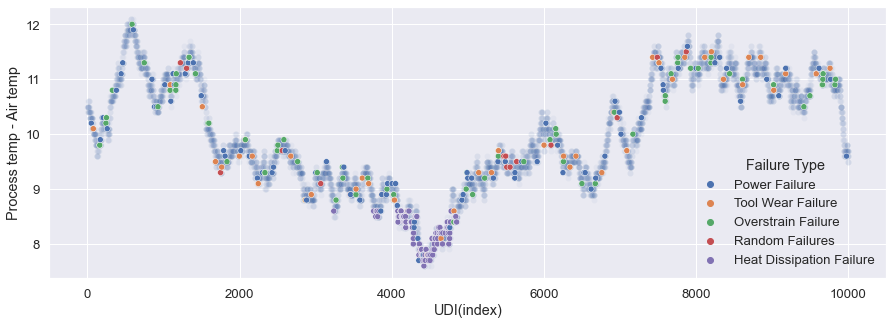

In [11]:
plt.figure(figsize=(15,5))
sns.scatterplot(x=df_org.index, y=df_org['Process temperature [K]']-df_org['Air temperature [K]'], alpha=0.05, data=df_org)
sns.scatterplot(x=df_fail.index, y=df_fail['Process temperature [K]']-df_fail['Air temperature [K]'],
            hue='Failure Type', data=df_fail)
plt.xlabel('UDI(index)')
plt.ylabel('Process temp - Air temp')

+ 공정 외부와 내부 온도가 높고, 둘의 차이가 적을때 Heat Dissipation Failure(보라색)이 일어나는 것으로 보임

### 2.2 전처리
+ 목표 변수 : Failure Type
+ 변수제거
    + target(고장유무)을 제외 (target이 아닌 Failure Type을 y로 두고 분류하려 함)
    + 의미가 없어보이는 product id 제외
+ 범주형 변수 더미화
    + Type

In [694]:
df = pd.concat([pd.get_dummies(df_org['Type']), df_org[['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Failure Type']]],axis=1)
df.rename(columns = {'H' : 'Type_H', 'L' : 'Type_L','M':'Type_M'}, inplace = True)
df.head()

,Type_H,Type_L,Type_M,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Failure Type
UDI,,,,,,,,,
1,0,0,1,298.1,308.6,1551,42.8,0,No Failure
2,0,1,0,298.2,308.7,1408,46.3,3,No Failure
3,0,1,0,298.1,308.5,1498,49.4,5,No Failure
4,0,1,0,298.2,308.6,1433,39.5,7,No Failure
5,0,1,0,298.2,308.7,1408,40.0,9,No Failure


## 3. Classification Using DT
### 3.1 split dataset

In [838]:
from sklearn.model_selection import train_test_split
from sklearn import tree
import graphviz
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, recall_score

In [865]:
X = df.drop('Failure Type', axis=1)
y = df['Failure Type']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8, random_state=123)

In [866]:
ytrain.value_counts()

No Failure                  7729
Heat Dissipation Failure      96
Power Failure                 75
Overstrain Failure            54
Tool Wear Failure             33
Random Failures               13
Name: Failure Type, dtype: int64

### 3.2 classification
+ 디시전트리 사용

In [879]:
model = tree.DecisionTreeClassifier(criterion='entropy', min_samples_leaf=0.001, max_depth=5, random_state=1234)
model.fit(Xtrain, ytrain)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=0.001,
                       random_state=1234)

### 3.3 Performance
+ imbalnced data이기에 Accuracy보다는 F1 score
+ 다중 클래스라서 F1 score micro를 사용
+ 특히 recall : 실제 고장을 고장이 났다고 예측한 비율. 고장이 난 걸 제대로 분류하는게 중요

In [880]:
y_model = model.predict(Xtest)

In [881]:
accuracy_score(ytest, y_model)

0.969

In [882]:
f1_score(ytest, y_model, average='macro')

0.4316480287897064

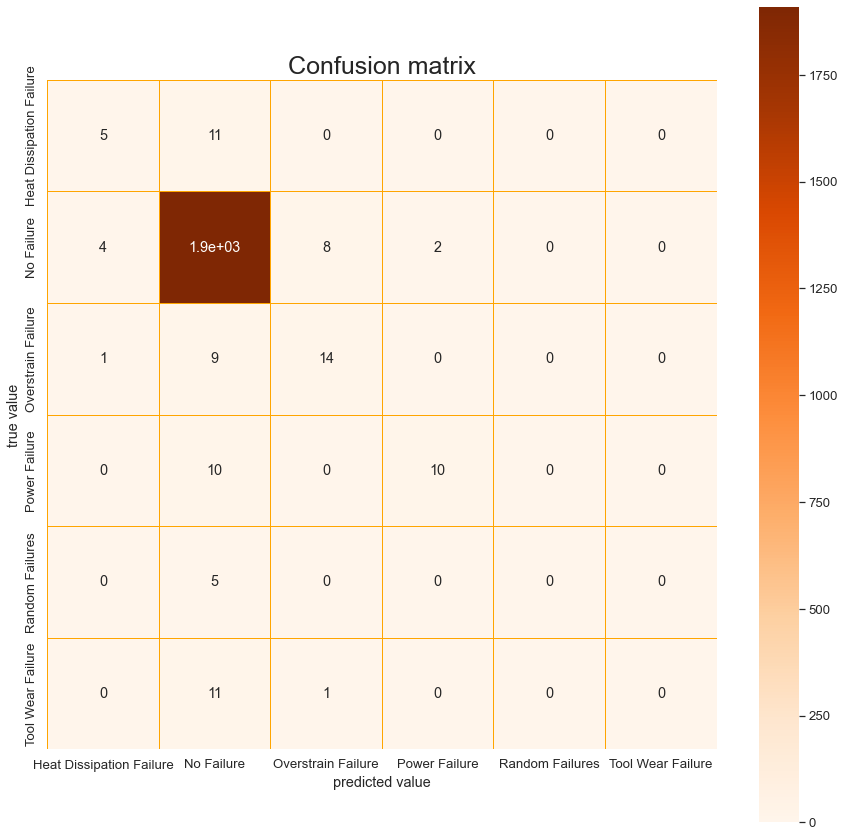

In [883]:
plt.figure(figsize=(15,15))
cmat = confusion_matrix(ytest, model.predict(Xtest))
#cmat=cmat[[0,2,3,4,5],[[0],[2],[3],[4],[5]]]
sns.heatmap(cmat, square=True, annot=True, cmap='Oranges',cbar=True, linewidths=0.5,linecolor='orange')
plt.xticks(np.arange(0.5, len(model.classes_), 1), model.classes_)
plt.yticks(np.arange(0.5, len(model.classes_), 1), model.classes_)
plt.title('Confusion matrix', fontsize = 25)
plt.xlabel('predicted value')
plt.ylabel('true value');

+ PowerFailure는 10개는 맞췄으나 나머지 10개는 정상으로 분류함. 잘 분류하지 못했음
+ Random Failure와 Tool wear failure은 거의 정상으로 분류함. 분류가 잘 안됨

### 3.4 Visualization

In [877]:
model.classes_

array(['Heat Dissipation Failure', 'No Failure', 'Overstrain Failure',
       'Power Failure', 'Random Failures', 'Tool Wear Failure'],
      dtype=object)

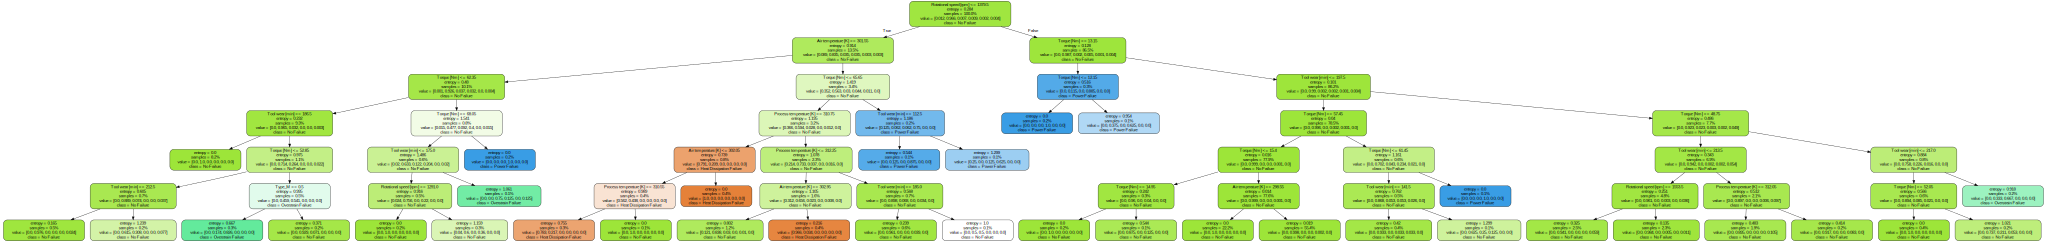

In [878]:
dot_data = tree.export_graphviz(model, out_file=None, feature_names=X.columns,   
                                class_names=model.classes_,  
                                filled=True, rounded=True,
                                proportion=True)
graph = graphviz.Source(dot_data)
graph

In [590]:
print(tree.export_text(model, feature_names=list(X.columns)))

|--- Tool wear [min] <= 175.50
|   |--- Rotational speed [rpm] <= 1380.00
|   |   |--- Torque [Nm] <= 62.45
|   |   |   |--- Tool wear [min] <= 169.00
|   |   |   |   |--- Type_H <= 0.50
|   |   |   |   |   |--- class: Heat Dissipation Failure
|   |   |   |   |--- Type_H >  0.50
|   |   |   |   |   |--- Tool wear [min] <= 16.00
|   |   |   |   |   |   |--- class: Random Failures
|   |   |   |   |   |--- Tool wear [min] >  16.00
|   |   |   |   |   |   |--- class: Heat Dissipation Failure
|   |   |   |--- Tool wear [min] >  169.00
|   |   |   |   |--- Torque [Nm] <= 56.15
|   |   |   |   |   |--- class: Heat Dissipation Failure
|   |   |   |   |--- Torque [Nm] >  56.15
|   |   |   |   |   |--- class: Random Failures
|   |   |--- Torque [Nm] >  62.45
|   |   |   |--- Torque [Nm] <= 64.60
|   |   |   |   |--- Rotational speed [rpm] <= 1327.00
|   |   |   |   |   |--- class: Heat Dissipation Failure
|   |   |   |   |--- Rotational speed [rpm] >  1327.00
|   |   |   |   |   |--- class: Powe

### 3.5 UnderSampling
+ 불균형 데이터라 몇몇 클래스는 분류가 잘 안됨
+ 정상인 sample을 랜덤으로 뽑아서 줄임
+ 정상과 고장 smaple 수가 1:1이 되게

In [888]:
df2=df.copy()
no_Failure_ind = df2[df2['Failure Type'] == 'No Failure'].index
failure = df2[df2['Failure Type'] != 'No Failure']
random_ind = np.random.choice(no_Failure_ind, 1*len(failure), replace=False)
failure_ind = df2[df2['Failure Type'] != 'No Failure'].index
undersample_ind = np.concatenate([failure_ind, random_ind])
undersample = df2.loc[undersample_ind]

In [889]:
X = undersample.drop('Failure Type', axis=1)
y = undersample['Failure Type']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8, random_state=1234)

model = tree.DecisionTreeClassifier(criterion='entropy', min_samples_leaf=0.001, max_depth=4, random_state=1234)
model.fit(Xtrain, ytrain)
y_model = model.predict(Xtest)

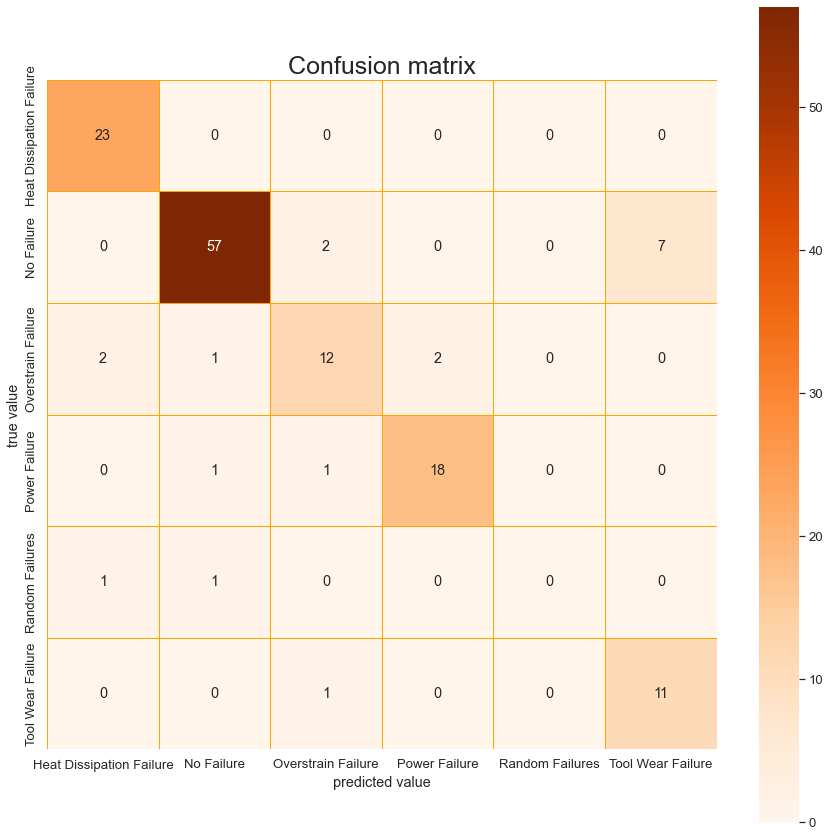

In [890]:
plt.figure(figsize=(15,15))
cmat = confusion_matrix(ytest, model.predict(Xtest))
#cmat=cmat[[0,2,3,4,5],[[0],[2],[3],[4],[5]]]
sns.heatmap(cmat, square=True, annot=True, cmap='Oranges',cbar=True, linewidths=0.5,linecolor='orange')
plt.xticks(np.arange(0.5, len(model.classes_), 1), model.classes_)
plt.yticks(np.arange(0.5, len(model.classes_), 1), model.classes_)
plt.title('Confusion matrix', fontsize = 25)
plt.xlabel('predicted value')
plt.ylabel('true value');

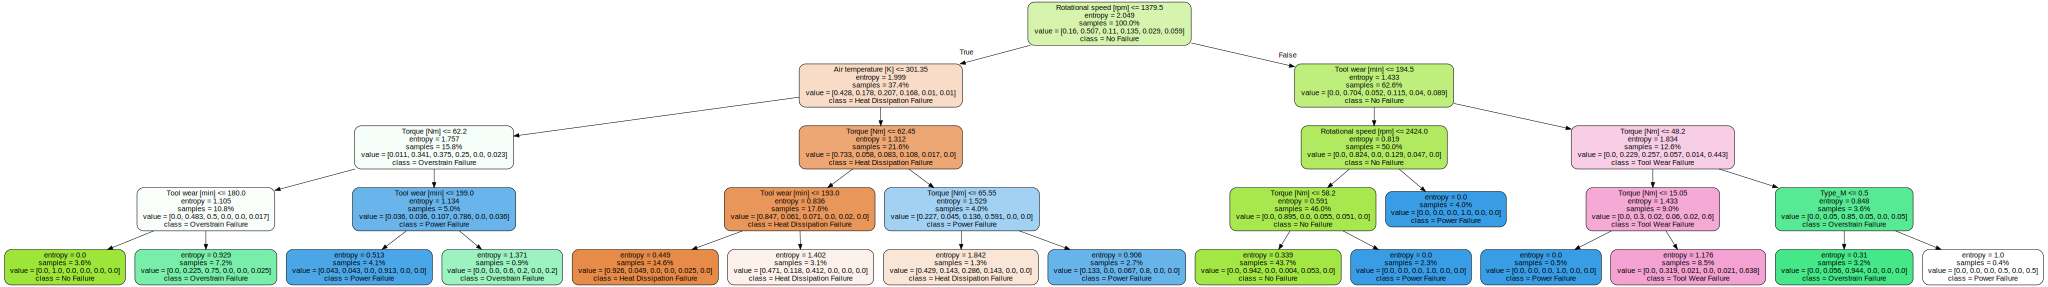

In [891]:
dot_data = tree.export_graphviz(model, out_file=None, feature_names=X.columns,   
                                class_names=model.classes_,  
                                filled=True, rounded=True,
                                proportion=True)
graph = graphviz.Source(dot_data)
graph

In [746]:
print(tree.export_text(model, feature_names=list(X.columns)))

|--- Rotational speed [rpm] <= 1379.50
|   |--- Air temperature [K] <= 301.55
|   |   |--- Torque [Nm] <= 62.20
|   |   |   |--- Tool wear [min] <= 186.50
|   |   |   |   |--- class: No Failure
|   |   |   |--- Tool wear [min] >  186.50
|   |   |   |   |--- class: Overstrain Failure
|   |   |--- Torque [Nm] >  62.20
|   |   |   |--- Tool wear [min] <= 199.00
|   |   |   |   |--- class: Power Failure
|   |   |   |--- Tool wear [min] >  199.00
|   |   |   |   |--- class: Overstrain Failure
|   |--- Air temperature [K] >  301.55
|   |   |--- Torque [Nm] <= 65.65
|   |   |   |--- Tool wear [min] <= 181.00
|   |   |   |   |--- class: Heat Dissipation Failure
|   |   |   |--- Tool wear [min] >  181.00
|   |   |   |   |--- class: Heat Dissipation Failure
|   |   |--- Torque [Nm] >  65.65
|   |   |   |--- Rotational speed [rpm] <= 1267.00
|   |   |   |   |--- class: Heat Dissipation Failure
|   |   |   |--- Rotational speed [rpm] >  1267.00
|   |   |   |   |--- class: Power Failure
|--- Rotati

## 4. Conclusion

In [474]:
df_org.columns

Index(['Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Target',
       'Failure Type'],
      dtype='object')

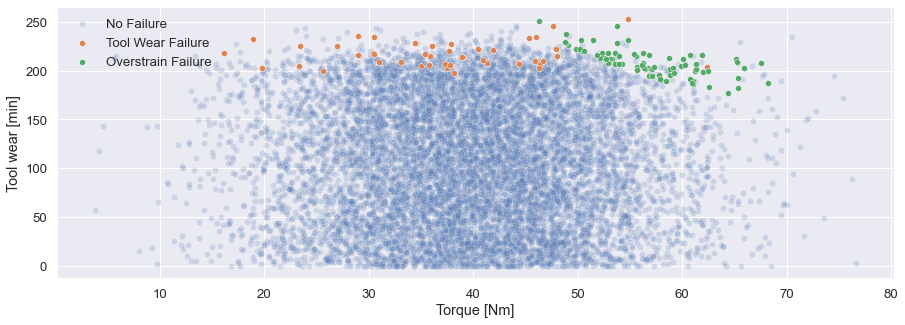

In [956]:
plt.figure(figsize=(15,5))

df_toolfailure = df_org[df_org['Failure Type']=='Tool Wear Failure']
df_overstrain = df_org[df_org['Failure Type']=='Overstrain Failure']
df_heat = df_org[df_org['Failure Type']=='Heat Dissipation Failure']

x='Torque [Nm]'
y='Tool wear [min]'
sns.scatterplot(x=x, y=y, alpha=0.2, data=df_org)
sns.scatterplot(x=x, y=y,data=df_toolfailure)
sns.scatterplot(x=x, y=y,data=df_overstrain)
#sns.scatterplot(x=x, y=y,data=df_heat)
#plt.scatter(x=x,y=y,color='red',data=df_heat)
#plt.legend(['No Failure', 'Heat Dissipation Failure', 'Tool Wear Failure', 'Overstrain Failure'])
plt.legend(['No Failure', 'Tool Wear Failure', 'Overstrain Failure'])

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

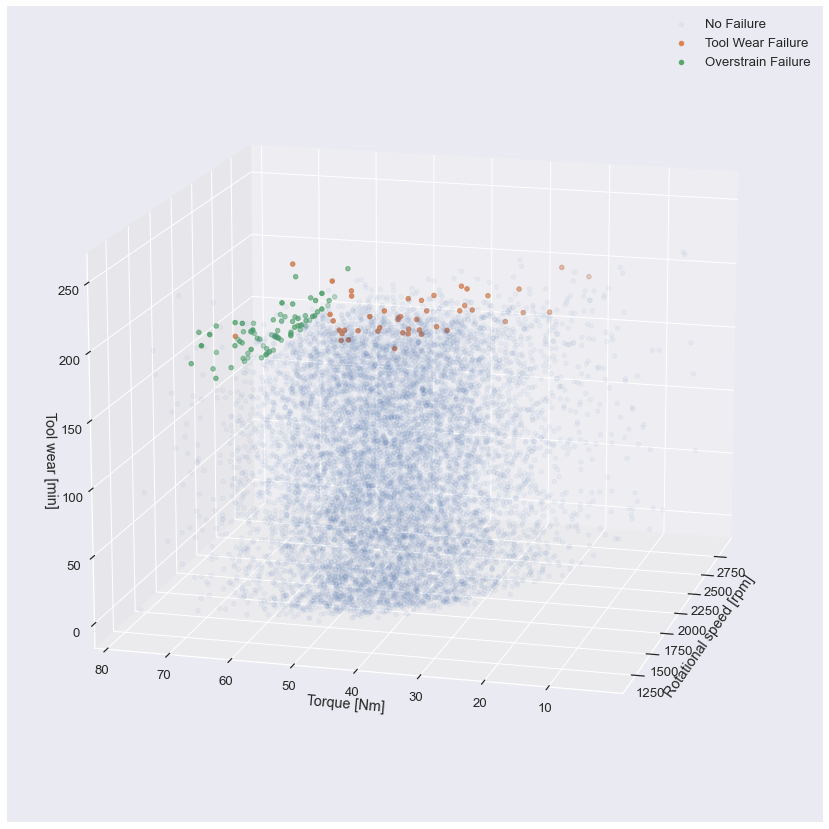

In [976]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection = '3d')

x = df['Rotational speed [rpm]']
y = df['Torque [Nm]']
z = df['Tool wear [min]']

ax.set_xlabel('Rotational speed [rpm]')
ax.set_ylabel('Torque [Nm]')
ax.set_zlabel('Tool wear [min]')
ax.scatter(x, y, z, alpha=0.05)

x = df_toolfailure['Rotational speed [rpm]']
y = df_toolfailure['Torque [Nm]']
z = df_toolfailure['Tool wear [min]']
ax.scatter(x, y, z)

x = df_overstrain['Rotational speed [rpm]']
y = df_overstrain['Torque [Nm]']
z = df_overstrain['Tool wear [min]']
ax.scatter(x, y, z)

ax.view_init(15,195)

plt.legend(['No Failure', 'Tool Wear Failure', 'Overstrain Failure'])


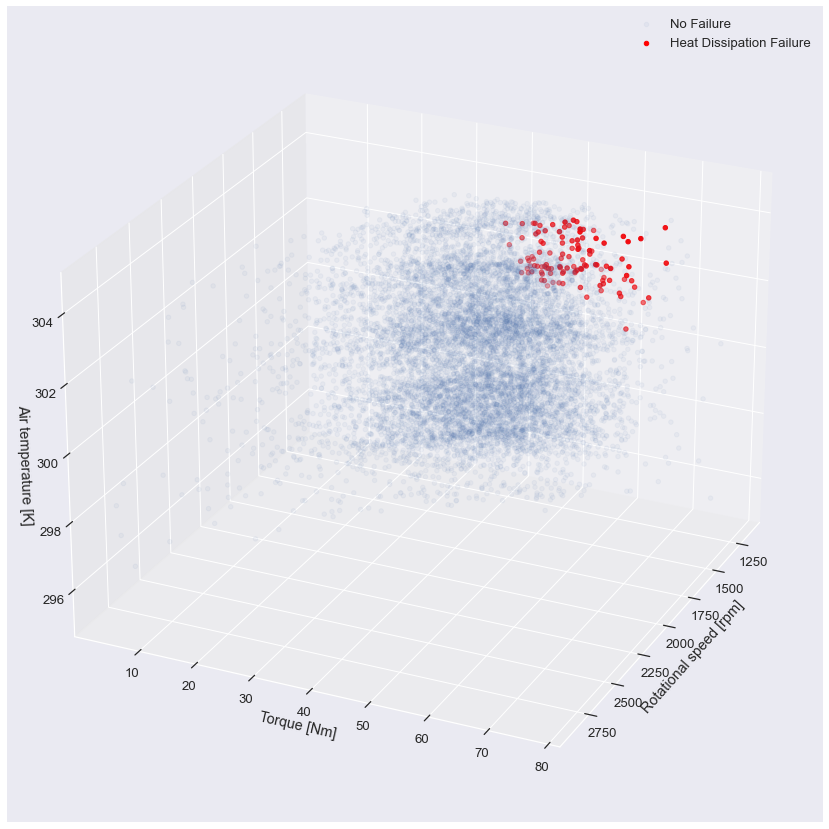

In [978]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection = '3d')

x = df['Rotational speed [rpm]']
y = df['Torque [Nm]']
z = df['Air temperature [K]']

ax.set_xlabel('Rotational speed [rpm]')
ax.set_ylabel('Torque [Nm]')
ax.set_zlabel('Air temperature [K]')
ax.scatter(x, y, z, alpha=0.05)

x = df_heat['Rotational speed [rpm]']
y = df_heat['Torque [Nm]']
z = df_heat['Air temperature [K]']
ax.scatter(x, y, z, color='red')
ax.view_init(25,25)

plt.legend(['No Failure', 'Heat Dissipation Failure'])